## Model 3 - RNN Based With Spacy

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import spacy

### 1 - Read the data

In [3]:
df = pd.read_csv("../../data/IMDB Dataset.csv")

def preprocess(x):
    x = re.sub("<br\\s*/?>", " ", x)
    return x    

df.review = df.review.apply(preprocess)
df.sentiment = df.sentiment == "positive"

In [4]:
x_train = df.review.values
y_train = df.sentiment.astype(int).values

### 2 - Fetch the embedding vector

In [9]:
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, Masking, GRU
from tensorflow.keras.models import Model

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam

In [10]:
nlp = spacy.load("en_core_web_md")

In [11]:
EMBEDDING_LAYER=96
MAX_SEQ_LEN = 200

x_train_embeedding = np.zeros((x_train.shape[0], MAX_SEQ_LEN, EMBEDDING_LAYER))
for idx, text in enumerate(x_train):
    doc = nlp(text)
    tensorized = doc.tensor
    x_train_embeedding[idx]=pad_sequences(np.transpose(tensorized), dtype='float32', maxlen=MAX_SEQ_LEN, padding='post', truncating='post').reshape(MAX_SEQ_LEN, EMBEDDING_LAYER)

### 3 - Build the model

In [12]:
def make_model(input_shape, n_hidden_lstm = 128, n_hidden_dense = 64):
    x = inp = Input(shape=input_shape)
    x = Masking()(x)
    x = LSTM(units=n_hidden_lstm)(x)
    x = Dense(units=n_hidden_dense, activation='relu')(x)
    x = Dropout(rate=0.2)(x)
    out = x = Dense(1, activation='sigmoid')(x)
    model = Model(inp, out)
    return model

In [13]:
model = make_model(input_shape=[MAX_SEQ_LEN, EMBEDDING_LAYER])
model.summary()
model.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200, 96)]         0         
_________________________________________________________________
masking (Masking)            (None, 200, 96)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 128)               115200    
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 123,521
Trainable params: 123,521
Non-trainable params: 0
_______________________________________________________

### 4 - Train

In [14]:
# set up the epoches to have better accuracy
def train(x_train, y_train, model, batch_size=1000):
    scores = []
    loss = []
    num_batch = int(x_train.shape[0] / batch_size)
    for i in range(num_batch-1):
        start = i * batch_size
        end = (i + 1) * batch_size
        history = model.fit(x_train[start:end], y_train[start:end], validation_data=(x_train, y_train), epochs=1)
        scores.append(history.history['val_accuracy'])
        loss.append(history.history['val_loss'])
    return scores

In [15]:
scores = train(x_train_embeedding, y_train, model)

Train on 1000 samples, validate on 50000 samples
1000/1000 [==============================] - 546s 546ms/sample - loss: 0.7059 - accuracy: 0.4800 - val_loss: 0.6965 - val_accuracy: 0.5101
Train on 1000 samples, validate on 50000 samples
1000/1000 [==============================] - 623s 623ms/sample - loss: 0.7041 - accuracy: 0.4970 - val_loss: 0.6940 - val_accuracy: 0.5188
Train on 1000 samples, validate on 50000 samples
1000/1000 [==============================] - 744s 744ms/sample - loss: 0.6992 - accuracy: 0.5270 - val_loss: 0.6908 - val_accuracy: 0.5283
Train on 1000 samples, validate on 50000 samples
1000/1000 [==============================] - 12394s 12s/sample - loss: 0.6996 - accuracy: 0.5060 - val_loss: 0.6901 - val_accuracy: 0.5312
Train on 1000 samples, validate on 50000 samples
1000/1000 [==============================] - 719s 719ms/sample - loss: 0.6957 - accuracy: 0.5150 - val_loss: 0.6878 - val_accuracy: 0.5411
Train on 1000 samples, validate on 50000 samples
1000/1000 [

1000/1000 [==============================] - 781s 781ms/sample - loss: 0.6779 - accuracy: 0.5660 - val_loss: 0.6513 - val_accuracy: 0.6346
Train on 1000 samples, validate on 50000 samples
1000/1000 [==============================] - 704s 704ms/sample - loss: 0.6798 - accuracy: 0.5820 - val_loss: 0.6504 - val_accuracy: 0.6362
Train on 1000 samples, validate on 50000 samples
1000/1000 [==============================] - 528s 528ms/sample - loss: 0.6717 - accuracy: 0.5810 - val_loss: 0.6486 - val_accuracy: 0.6335
Train on 1000 samples, validate on 50000 samples
1000/1000 [==============================] - 518s 518ms/sample - loss: 0.6715 - accuracy: 0.6020 - val_loss: 0.6460 - val_accuracy: 0.6328
Train on 1000 samples, validate on 50000 samples
1000/1000 [==============================] - 517s 517ms/sample - loss: 0.6847 - accuracy: 0.5720 - val_loss: 0.6468 - val_accuracy: 0.6372
Train on 1000 samples, validate on 50000 samples
1000/1000 [==============================] - 517s 517ms/samp

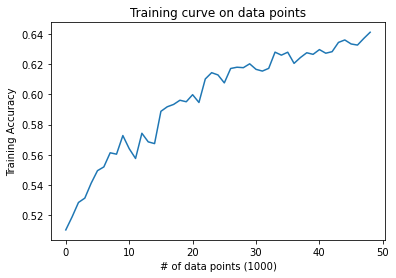

In [16]:
plt.plot(scores, label='Train Accuracy')
plt.xlabel('# of data points (1000)')
plt.ylabel('Training Accuracy')
plt.title('Training curve on data points')
plt.show()